# Continuous Control PPO

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [21]:
from unityagents import UnityEnvironment
import numpy as np

# import general stuff
import gym
import random
import torch
import numpy as np
from collections import deque
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
# widget bar to display progress
!pip install progressbar
import progressbar as pb

# import specific / own stuff
from ppo_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [22]:
env = UnityEnvironment(file_name='.\Reacher_Windows_x86_64\Reacher.exe')

OSError: handle is closed

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [23]:
# get the default brain
brain_name = env.brain_names[0]

brain = env.brains[brain_name]

print(brain_name)

ReacherBrain


ERROR:root:Exception calling application: [WinError 232] Die Pipe wird gerade geschlossen
Traceback (most recent call last):
  File "C:\Users\adria\Anaconda3\envs\drlnd\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "C:\Users\adria\Anaconda3\envs\drlnd\lib\site-packages\unityagents\rpc_communicator.py", line 25, in Exchange
    self.child_conn.send(request)
  File "C:\Users\adria\Anaconda3\envs\drlnd\lib\multiprocessing\connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "C:\Users\adria\Anaconda3\envs\drlnd\lib\multiprocessing\connection.py", line 280, in _send_bytes
    ov, err = _winapi.WriteFile(self._handle, buf, overlapped=True)
BrokenPipeError: [WinError 232] Die Pipe wird gerade geschlossen
ERROR:root:Exception calling application: [WinError 232] Die Pipe wird gerade geschlossen
Traceback (most recent call last):
  File "C:\Users\adria\Anaconda3\envs\drlnd\lib\site-packages

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# random actions
actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
print('Random set of actions: {}'.format(actions))

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There is/are {} agent(s). Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Number of actions: 4
Random set of actions: [[ 1.         -0.69797296 -0.66025489 -0.59108344]]
There is/are 1 agent(s). Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. [optional] Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

In [5]:
if False:
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    nsteps = 0
    #for _ in range(1, 50):
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        nsteps +=1
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
    print('Number of time steps is {}'.format(nsteps))

### 4. Let's start training!

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
env_info = env.reset(train_mode=True)[brain_name]

#### define AC with PPO

In [7]:
def ac_ppo(n_episodes=100, max_t=100, beta_start=1.0, beta_end=0.01, beta_episodeEnd=80):
    """Deep Deterministic Policy Gradient.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps
        beta_start (float): starting value of epsilon, for epsilon-greedy action selection
        beta_end (float): minimum value of epsilon
        beta_episodeEnd (float): number of episodes for which eps_end is reached
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    beta = beta_start                  # initialize beta, that is factor for adding noise
    beta_decay_linear = (beta_start-beta_end)/beta_episodeEnd # compute linear beta decay rate
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset unity enviroment
        state = env_info.vector_observations[0]            # get the current state 
        score = 0.0
        
        # variables for collecting the trajectories
        states_epi = []
        actions_epi = []
        rewards_epi = []
        done_epi = []
        
        for t in range(max_t):
            # choose action and perform it
            action = agent.act(state, beta, add_noise=False)
            env_info = env.step(action)[brain_name]       # send the actions to the environment
            
            # send env data to agent and initiate learning
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            # collect the trajectory
            states_epi.append(state)
            actions_epi.append(action)
            rewards_epi.append([reward])
            done_epi.append([done])
            
            # do some tracking on the rewards
            state = next_state
            score += reward
            
            if done:
                break 
      
        # step agent and make agent learn for next episode
        if i_episode % 100 == 0:
            agent.step(states_epi, actions_epi, rewards_epi, done_epi, beta, infos=True)
        else:
            agent.step(states_epi, actions_epi, rewards_epi, done_epi, beta)
        
        # scoring and decrease of exploration
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        beta = max(beta_end, beta_start - beta_decay_linear*i_episode) # decrease beta
        
        # generate output to see how things are going
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 50 == 0:
            # update progress widget bar
            timer.update(i_episode)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=30:
            # yeaaah, we did it!
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            break
            
    # finish timer
    timer.finish()    
    return scores

#### create the agent and do the training

Episode 49	Average Score: 0.46

Episode 50	Average Score: 0.45
Episode 99	Average Score: 0.53

------------------------------
rewards sum: 0.001937822438776493


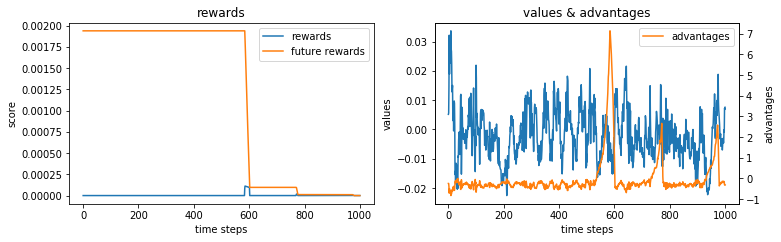

Episode 100	Average Score: 0.54
Episode 149	Average Score: 0.62

Episode 150	Average Score: 0.63
Episode 199	Average Score: 0.67

------------------------------
rewards sum: 0.30828675627708435


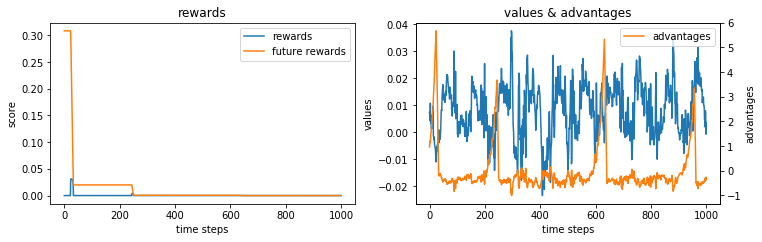

Episode 200	Average Score: 0.67
Episode 249	Average Score: 0.77

Episode 250	Average Score: 0.76
Episode 299	Average Score: 0.71

------------------------------
rewards sum: 0.0


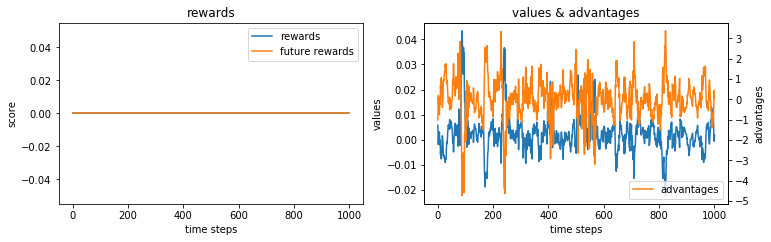

Episode 300	Average Score: 0.70
Episode 349	Average Score: 0.43

Episode 350	Average Score: 0.43
Episode 399	Average Score: 0.30

------------------------------
rewards sum: 6.763156852684915e-05


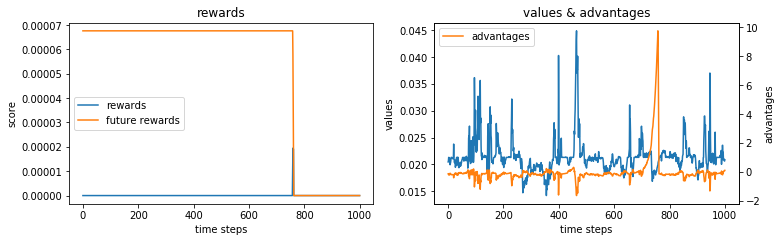

Episode 400	Average Score: 0.30
Episode 449	Average Score: 0.25

Episode 450	Average Score: 0.25
Episode 499	Average Score: 0.18

------------------------------
rewards sum: 0.002543470822274685


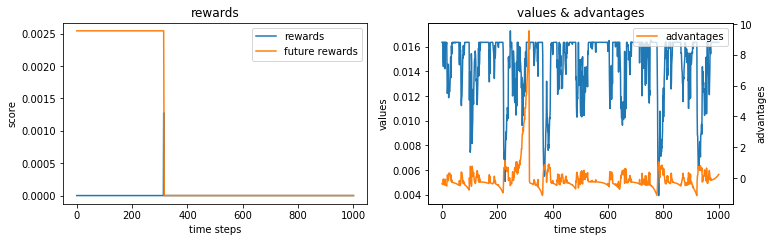

Episode 500	Average Score: 0.18
Episode 549	Average Score: 0.13

Episode 550	Average Score: 0.13
Episode 599	Average Score: 0.10

------------------------------
rewards sum: 0.005630836356431246


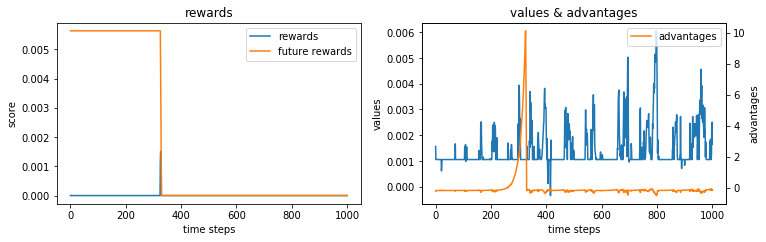

Episode 600	Average Score: 0.10
Episode 649	Average Score: 0.11

Episode 650	Average Score: 0.11
Episode 699	Average Score: 0.14

------------------------------
rewards sum: 0.0


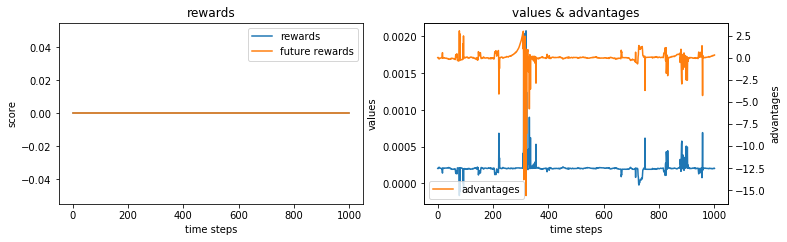

Episode 700	Average Score: 0.14
Episode 749	Average Score: 0.17

Episode 750	Average Score: 0.18
Episode 799	Average Score: 0.18

------------------------------
rewards sum: 0.0005049415631219745


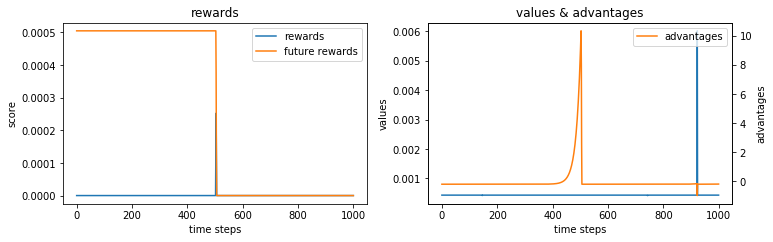

Episode 800	Average Score: 0.18
Episode 849	Average Score: 0.17

Episode 850	Average Score: 0.16
Episode 899	Average Score: 0.12

------------------------------
rewards sum: 0.0


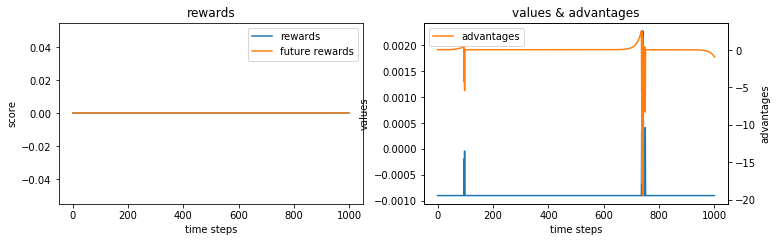

Episode 900	Average Score: 0.12
Episode 949	Average Score: 0.11

Episode 950	Average Score: 0.11
Episode 999	Average Score: 0.13

------------------------------
rewards sum: 0.0


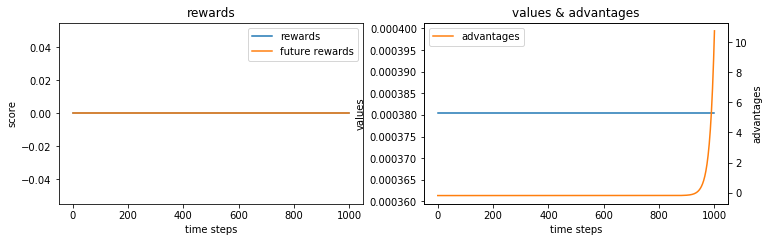

Episode 1000	Average Score: 0.13


In [8]:
# parameters for learning
max_t=2000
beta_start=1.0
beta_end=0.01
n_episodes=1000
beta_episodeEnd=n_episodes

# create agent and train
agent = Agent(state_size, action_size, 1)        # initialize agent
# create progress bar to keep track 
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=n_episodes).start()

# do actual learning
scores = ac_ppo(n_episodes, max_t, beta_start, beta_end, beta_episodeEnd)


#### draw the resulting scores

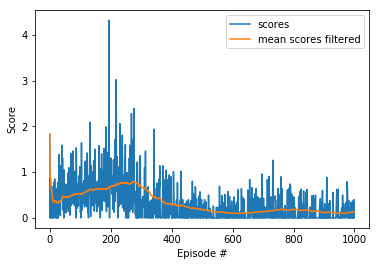

In [9]:
def moving_average(sig, n=100):
    window = deque(maxlen=n)  # last n scores
    sig_ma = []
    for i in range(len(sig)):
        window.append(sig[i])
        sig_ma.append(np.mean(window))
    return sig_ma

scores_filtered = moving_average(scores)
plt.plot(scores, label='scores')
plt.plot(scores_filtered, label='mean scores filtered')
plt.legend(loc='best')
plt.ylabel('Score')
plt.xlabel('Episode #')
#plt.savefig('./data/PPO_tmax{}_episodes{}_twoHiddenlayer.png'.format(max_t, n_episodes))
plt.show()

In [10]:
# save data
with open('./data/scores_PPO_tmax{}_episodes{}_twoHiddenlayer.pkl'.format(max_t, n_episodes), 'wb') as f:
    pickle.dump(scores, f)

In [11]:
#with open('./data/scores_DDPG_tmax2000_episodes500.pkl', 'rb') as f:
#    scores = pickle.load(f)

In [12]:
# save learned agent if desired
checkpoint = {'input_size': state_size,
              'output_size': 1,
              'hidden_layers': [each.out_features for each in agent.vnetwork.hidden_layers],
              'state_dict': agent.vnetwork.state_dict()}
torch.save(checkpoint, './data/checkpoint_PPO_vnetwork.pth')

checkpoint = {'input_size': state_size,
              'output_size': action_size,
              'hidden_layers': [each.out_features for each in agent.munetwork.hidden_layers],
              'state_dict': agent.munetwork.state_dict()}
torch.save(checkpoint, './data/checkpoint_PPO_munetwork.pth')


### 5. watch trained agent playing

In [24]:
# load from save
agent = Agent(state_size, action_size, 1)        # initialize agent
checkpoint = torch.load('./data/checkpoint_PPO_vnetwork.pth')
agent.vnetwork.load_state_dict(checkpoint['state_dict'])
checkpoint = torch.load('./data/checkpoint_PPO_munetwork.pth')
agent.munetwork.load_state_dict(checkpoint['state_dict'])

In [25]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    

UnityEnvironmentException: No Unity environment is loaded.

In [15]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
all_actions = np.zeros(num_agents)                     # initialize the score (for each agent)
for _ in range(1, 500):
    actions = agent.act(states, beta = 0., add_noise = False)      # select actions without 
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.2899999935179949


Close the environment.

In [16]:
env.close()

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(agent.vnetwork(torch.tensor(states, dtype=torch.float32, device=device)))
states_tensor = torch.tensor(states, dtype=torch.float32, device=device)
rewards_tensor  = torch.tensor(rewards, dtype=torch.float32, device=device)
#done_tensor  = torch.tensor(done, dtype=torch.float32, device=device)
#print(agent.compute_tderror(states_tensor, done))


tensor([[-0.0001]], device='cuda:0', grad_fn=<ThAddmmBackward>)


In [18]:
mu, dist = agent.munetwork.forward(torch.tensor(states, dtype=torch.float32, device=device))

In [19]:
dist.log_std

AttributeError: 'Normal' object has no attribute 'log_std'